**上面的代码与本程序无关**

In [ ]:
#环境与库的导入
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import paddle.nn as nn
from paddle.vision.transforms import Normalize
import paddle.optimizer as opt
import copy
import os
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [ ]:
#配置运算环境GPU或者CPUCPU

# 指定在 CPU 上训练
#paddle.device.set_device('cpu')

# 指定在 GPU 第 0 号卡上训练
paddle.device.set_device('gpu:0')



Place(gpu:0)

In [ ]:
#准备data loader
image_size = 28  #图像的总尺寸28*28
batch_size = 16  #批处理的尺寸大小
val_size = 5000  #验证集数量，从testtest dataset里面分出来

# 为了比较不同数据量对迁移学习的影响，我们设定了一个加载数据的比例fraction
# 即我们只加载原训练数据集的1/fraction来训练网络
fraction = 1

train_loader1 = paddle.io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader2 = paddle.io.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#定义一个 数据集切片器，参数：原数据集、切片的开头、切片的结尾，如：test_dataset, 0, 9999
class SliceDataset(paddle.io.Dataset):
    def __init__(self, original_dataset, start, end):
        self.original_dataset = original_dataset
        self.start = start
        self.end = end

    def __getitem__(self, idx):
        image = self.original_dataset[idx+self.start][0]
        label = self.original_dataset[idx+self.start][1]
        return image, label

    def __len__(self):
        return self.end - self.start + 1

#将原有的测试集分为测试集和训练集
val_dataset = SliceDataset(test_dataset, 0 ,val_size)
new_test_dataset = SliceDataset(test_dataset, val_size, len(test_dataset)-1)

val_loader1 = paddle.io.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
val_loader2 = paddle.io.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_loader1 = paddle.io.DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True)
test_loader2 = paddle.io.DataLoader(new_test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
#接下来训练预训练网络

#定义预训练模型的 网络结构
depth = [4, 8]
class ConvNet_pre_train(nn.Layer):
    def __init__(self, num_class = 10):
        super(ConvNet_pre_train, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2D(1, 4, 5, stride=1, padding=2) #前三个参数分别为 input_ch, output_ch, kernel_size
        self.conv2 = nn.Conv2D(4, 8, 5, stride=1, padding=2)
        self.pool  = nn.MaxPool2D(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(392,512)
        self.fc2 = nn.Linear(512,num_class)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = paddle.flatten(x, 1) #flatten

        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x) #log_softmax可以理解为概率对数值
        return x


pre_train_net = ConvNet_pre_train()  #网络实例化
pre_train_model = paddle.Model(pre_train_net)   # 封装模型为一个 model 实例，便于进行后续的训练、评估和推理

lr = 0.001 #学习率
epochs = 20
batch_size = 32

# 为模型训练做准备，设置优化器及其学习率，并将网络的参数传入优化器，设置损失函数和精度计算方式
pre_train_model.prepare(optimizer=paddle.optimizer.Adam(learning_rate=lr, parameters=pre_train_model.parameters()), 
              loss=paddle.nn.CrossEntropyLoss(), 
              metrics=paddle.metric.Accuracy())

#配置call back 使用realyrealy stopping
callbacks = paddle.callbacks.EarlyStopping(
    'loss',
    mode='min',
    patience=2,
    min_delta=0.001,
    save_best_model=True)


#训练模型 
pre_train_model.fit(train_data = train_dataset,  #根本不需要用到data loader，这里已经高度集成了
        eval_data = test_dataset,  
        epochs=epochs, 
        batch_size=batch_size,
        verbose=1,  #显示训练过程
        save_dir = './pre_traim_model_2/',  #模型保存的路径
        save_freq = epochs,  #最后训练完再自动保存，默认为1，即每个epoch自动保存模型一次
        callbacks=[callbacks]
        )


The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/20
step 1875/1875 [==============================] - loss: 0.0271 - acc: 0.9438 - 17ms/step        
save checkpoint at /home/aistudio/pre_traim_model_2/0
Eval begin...
step 313/313 [==============================] - loss: 0.0016 - acc: 0.9794 - 8ms/step         
Eval samples: 10000
Epoch 2/20
step 1875/1875 [==============================] - loss: 0.0168 - acc: 0.9754 - 17ms/step        
Eval begin...
step 313/313 [==============================] - loss: 3.7234e-04 - acc: 0.9853 - 7ms/step       
Eval samples: 10000
Epoch 3/20
step 1875/1875 [==============================] - loss: 0.0180 - acc: 0.9809 - 17ms/step        
Eval begin...
step 313/313 [==============================] - loss: 3.4612e-04 - acc: 0.9876 - 7ms/step       
Eval samples: 10000
Epoch 4/20
step 1875/1875 [==============================] - loss: 0.0315 - acc: 0.9849 - 17ms/step         
Eval begin..

In [ ]:
#定义预训练模型的 网络结构 载入预训练模型
depth = [4, 8]
class ConvNet_pre_train(nn.Layer):
    def __init__(self, num_class = 10):
        super(ConvNet_pre_train, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv2D(1, 4, 5, stride=1, padding=2) #前三个参数分别为 input_ch, output_ch, kernel_size
        self.conv2 = nn.Conv2D(4, 8, 5, stride=1, padding=2)
        self.pool  = nn.MaxPool2D(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(392,512)#线性变换输入输出大小
        self.fc2 = nn.Linear(512,num_class)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = paddle.flatten(x, 1) #flatten

        x = F.relu(self.fc1(x)) #全链接，激活函数
        x = F.dropout(x, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        x = self.fc2(x) #全链接，激活函数
        x = F.log_softmax(x) #log_softmax可以理解为概率对数值
        return x


#模型载入
pre_train_state_dict = paddle.load("./pre_traim_model_2/best_model.pdparams") #从文件夹里面载入

pre_train = ConvNet_pre_train()  #实例化出一个空的网络
pre_train.set_state_dict(pre_train_state_dict)  #将参数载入空网络中

W0627 09:46:15.220721   103 gpu_context.cc:278] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0627 09:46:15.237273   103 gpu_context.cc:306] device: 0, cuDNN Version: 7.6.


In [ ]:
#定义Transfer网络
image_size = 28
depth = [4, 8]
class Transfer(nn.Layer):
    def __init__(self):
        super(Transfer, self).__init__()
        # 两个并行的卷积通道，第一个通道：
        self.net1_conv1 = nn.Conv2D(1, 4, 5, padding = 2) #一个输入通道，4个输出通道（4个卷积核），窗口为5，填充2
        self.net_pool = nn.MaxPool2D(2, 2) #2*2 池化
        self.net1_conv2 = nn.Conv2D(depth[0], depth[1], 5, padding = 2) #输入通道4，输出通道8（8个卷积核），窗口5，填充2
        
        # 第二个通道，注意pooling操作不需要重复定义
        self.net2_conv1 = nn.Conv2D(1, 4, 5, padding = 2) #一个输入通道，4个输出通道（4个卷积核），窗口为5，填充2
        self.net2_conv2 = nn.Conv2D(depth[0], depth[1], 5, padding = 2) #输入通道4，输出通道8（8个卷积核），窗口5，填充2
        
        # 全链接层
        
        my_num_clas = 19
        
        self.fc1 = nn.Linear(2 * image_size // 4 * image_size // 4 * depth[1] , 1024) #输入为处理后的特征图压平，输出1024个单元
        self.fc2 = nn.Linear(1024, 2 * my_num_clas) #输入1024个单元，输出2 * num_classes个单元
        self.fc3 = nn.Linear(2 * my_num_clas, my_num_clas) #输入2 * num_classes个单元，输出num_classes个单元
        self.fc4 = nn.Linear(my_num_clas, my_num_clas) #输入num_classes个单元，输出为1

    def forward(self, x, y, training = True):
        # 网络的前馈过程。输入两张手写图像x和y，输出一个数字表示两个数字的和
        # x,y都是batch_size*image_size*image_size形状的三阶张量
        # 输出为batch_size长的列向量
        
        # 首先，第一张图像进入第一个通道
        x = F.relu(self.net1_conv1(x)) #第一层卷积
        x = self.net_pool(x)   # 第一层池化
        x = F.relu(self.net1_conv2(x))  # 第二层卷积
        x = self.net_pool(x) # 第二层池化
        x = paddle.flatten(x, start_axis=1) # 将特征图张量压平 ,不压第一个维度0，因为这是batch
        
        
        y = F.relu(self.net2_conv1(y)) #第一层卷积
        y = self.net_pool(y) # 第一层池化
        y = F.relu(self.net2_conv2(y)) #第二层卷积
        y = self.net_pool(y) #第二层池化
        y = paddle.flatten(y, start_axis=1)# 将特征图张量压平
        
        # 将两个卷积过来的铺平向量拼接在一起，形成一个大向量
        z = paddle.concat([x, y], 1) #cat函数为拼接向量操作，1表示拼接的维度为第1个维度（0维度对应了batch）
        z = self.fc1(z) #第一层全链接
        z = F.relu(z)  #对于深层网络来说，激活函数用relu效果会比较好
        z = F.dropout(z, training=self.training) #以默认为0.5的概率对这一层进行dropout操作
        z = self.fc2(z) #第二层全链接
        z = F.relu(z)
        z = self.fc3(z) #第三层全链接
        z = F.relu(z)
        z = self.fc4(z) # 第四层全链接
        return z

    def set_filter_values(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为预训练式
        # 输入参数net为从硬盘加载的网络作为迁移源
        
        # 逐个儿为网络的两个卷积模块的权重和偏置进行赋值
        # 注意在赋值的时候需要用deepcopy而不能直接等于，或者copy。
        # 这是因为这种拷贝是将张量中的数值全部拷贝到了目标中，而不是拷贝地址
        # 如果不用deepcopy，由于我们将同一组参数（net.conv1.weight.data,bias）
        #  赋予了两组参数（net1_conv1.weight.data，net2_conv1.weight.data）
        # 所以它们会共享源net.conv1.weight.data中的地址，这样对于net1_conv1.weight.data
        # 的训练也自然会被用到了net2_conv1.weight.data中，但其实我们希望它们是两个不同的参数。
        self.net1_conv1.weight = copy.deepcopy(net.conv1.weight)
        self.net1_conv1.bias = copy.deepcopy(net.conv1.bias)
        self.net1_conv2.weight = copy.deepcopy(net.conv2.weight)
        self.net1_conv2.bias = copy.deepcopy(net.conv2.bias)
        self.net2_conv1.weight = copy.deepcopy(net.conv1.weight)
        self.net2_conv1.bias = copy.deepcopy(net.conv1.bias)
        self.net2_conv2.weight = copy.deepcopy(net.conv2.weight)
        self.net2_conv2.bias = copy.deepcopy(net.conv2.bias)

        '''
        # 将变量加载到GPU上        
        self.net1_conv1 = self.net1_conv1.cuda() if use_cuda else self.net1_conv1
        self.net1_conv2 = self.net1_conv2.cuda() if use_cuda else self.net1_conv2
        
        self.net2_conv1 = self.net2_conv1.cuda() if use_cuda else self.net2_conv1
        self.net2_conv2 = self.net2_conv2.cuda() if use_cuda else self.net2_conv2
        '''
    def set_filter_values_nograd(self, net):
        # 本函数为迁移网络所用，即将迁移过来的网络的权重值拷贝到本网络中
        # 本函数对应的迁移为固定权重式
        # 调用set_filter_values为全部卷积核进行赋值
        self.set_filter_values(net)
        
        # 为了让我们的网络不被训练调整权值，我们需要设定每一个变量的stop_gradient 为True
        # 即不需要计算梯度值
        self.net1_conv1.weight.stop_gradient = True
        self.net1_conv1.bias.stop_gradient = True
        self.net1_conv2.weight.stop_gradient = True
        self.net1_conv2.bias.stop_gradient = True
        
        self.net2_conv1.weight.stop_gradient = True
        self.net2_conv1.bias.stop_gradient = True
        self.net2_conv2.weight.stop_gradient = True
        self.net2_conv2.bias.stop_gradient = True

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行10列的矩阵，labels是数据之中的正确答案"""
    rights = 0
    for i in range(len(labels)):
        pred_max = paddle.max(predictions[i]) #得到19个概率的最大值
        for j in range(len(predictions[i])):
            if predictions[i][j]==pred_max:
                pred_index = j #预测的下标，也就是数值
                break
        if pred_index == labels[i]:
            rights+=1
    
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

results = {}

训练网络1:无迁移

In [ ]:
# 生成网络实例
net1 = Transfer()

# 如果存在GPU，则将网络加载到GPU中
if use_cuda:
    net1 = net1.cuda()
    
criterion = nn.CrossEntropyLoss() #交叉熵损失函数
optimizer1 = opt.Adam(learning_rate=0.001, parameters=net1.parameters()) #优化器

records1 = [] #用于记录训练过程

In [ ]:
# 开始训练网络net1

num_epochs = 5

for epoch in range(num_epochs):
    losses = []
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        net1.train()
        optimizer1.clear_grad()

        x1 = x1.clone().detach()
        x1.stop_gradient = False
        x2 = x2.clone().detach()
        x2.stop_gradient = False
        
        #print(x1.shape)
        outputs = net1(x1, x2)
        labels = y1 + y2
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer1.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.numpy())
        if idx % 100 == 0:
            val_losses = []
            rights = []
            net1.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                
                x1 = x1.clone().detach()
                x1.stop_gradient = False
                x2 = x2.clone().detach()
                x2.stop_gradient = False

                outputs = net1(x1,x2)
                labels = y1 + y2
                loss = criterion(outputs, labels)
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.numpy())
                
                right = rightness(outputs, labels) #
                rights.append(right)

            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])

            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records1.append([np.mean(losses), np.mean(val_losses), right_ratio])

#测试
rights = []
net1.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    
    x1 = x1.clone().detach()
    x1.stop_gradient = False
    x2 = x2.clone().detach()
    x2.stop_gradient = False

    outputs = net1(x1,x2)
    labels = y1 + y2
    loss = criterion(outputs, labels)
    right = rightness(outputs, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['transfer1'] = [records1, right_ratio] 

第0周期，第(0/3750)个撮，训练误差：3.07, 校验误差：3.01, 准确率：0.07
第0周期，第(100/3750)个撮，训练误差：2.91, 校验误差：2.83, 准确率：0.08
第0周期，第(200/3750)个撮，训练误差：2.85, 校验误差：2.78, 准确率：0.11
第0周期，第(300/3750)个撮，训练误差：2.81, 校验误差：2.72, 准确率：0.11
第0周期，第(400/3750)个撮，训练误差：2.78, 校验误差：2.63, 准确率：0.12
第0周期，第(500/3750)个撮，训练误差：2.74, 校验误差：2.47, 准确率：0.15
第0周期，第(600/3750)个撮，训练误差：2.68, 校验误差：2.36, 准确率：0.17
第0周期，第(700/3750)个撮，训练误差：2.63, 校验误差：2.22, 准确率：0.21
第0周期，第(800/3750)个撮，训练误差：2.58, 校验误差：2.20, 准确率：0.22
第0周期，第(900/3750)个撮，训练误差：2.53, 校验误差：2.06, 准确率：0.27
第0周期，第(1000/3750)个撮，训练误差：2.48, 校验误差：2.03, 准确率：0.28
第0周期，第(1100/3750)个撮，训练误差：2.44, 校验误差：1.95, 准确率：0.31
第0周期，第(1200/3750)个撮，训练误差：2.39, 校验误差：1.88, 准确率：0.32
第0周期，第(1300/3750)个撮，训练误差：2.35, 校验误差：1.80, 准确率：0.36
第0周期，第(1400/3750)个撮，训练误差：2.31, 校验误差：1.77, 准确率：0.38
第0周期，第(1500/3750)个撮，训练误差：2.27, 校验误差：1.66, 准确率：0.41
第0周期，第(1600/3750)个撮，训练误差：2.24, 校验误差：1.61, 准确率：0.46
第0周期，第(1700/3750)个撮，训练误差：2.20, 校验误差：1.53, 准确率：0.49
第0周期，第(1800/3750)个撮，训练误差：2.16, 校验误差：1.39, 准确率：0.54
第0周期，第(1900/3750)个撮，训练误差：2.12, 校验误差：1.31, 准

In [ ]:
#保存模型
paddle.save(net1.state_dict(), "net1.pdparams")
paddle.save(optimizer1.state_dict(), "net1_optimizer.pdopt")

test acc: 0.9716


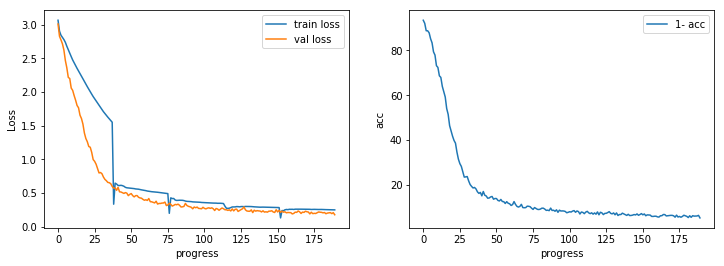

In [ ]:
#可视化训练过程
#绘制实验结果，打印测试集上的准确度
print('test acc:', right_ratio)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([i[0] for i in records1],label = 'train loss') #train loss
plt.plot([i[1] for i in records1],label = 'val loss') #val loss
plt.legend()
plt.xlabel("progress")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([100 * (1 - i[2]) for i in records1],label = '1- acc') #right ratio
plt.xlabel("progress")
plt.ylabel("acc")
plt.legend()
plt.show()

迁移学习net2，卷积层和全连接层都学习

In [ ]:
net2 = Transfer()

# 为新网络赋予权重数值，注意我们只将卷积部分的网络进行迁移，而没有迁移全链接层
net2.set_filter_values(pre_train)

if use_cuda:
    net2 = net2.cuda()

criterion = nn.CrossEntropyLoss()  

# 将需要训练的参数加载到优化器中
new_parameters = []
for para in net2.parameters():
    if not para.stop_gradient: #我们只将可以调整权重的变量加到了集合new_parameters
        new_parameters.append(para)
        
# 将new_parameters加载到了优化器中
optimizer = opt.Adam(learning_rate=0.001, parameters=new_parameters) #优化器

#记录训练过程
records2 = []

In [ ]:
# 开始训练网络net2 和之前一样的训练方法
num_epochs = 5

for epoch in range(num_epochs):
    losses = []
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        net2.train()
        optimizer.clear_grad()

        x1 = x1.clone().detach()
        x1.stop_gradient = False
        x2 = x2.clone().detach()
        x2.stop_gradient = False
        
        #print(x1.shape)
        outputs = net2(x1, x2)
        labels = y1 + y2
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.numpy())
        if idx % 100 == 0:
            val_losses = []
            rights = []
            net2.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                
                x1 = x1.clone().detach()
                x1.stop_gradient = False
                x2 = x2.clone().detach()
                x2.stop_gradient = False

                outputs = net2(x1,x2)
                labels = y1 + y2
                loss = criterion(outputs, labels)
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.numpy())
                
                right = rightness(outputs, labels) #
                rights.append(right)

            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records2.append([np.mean(losses), np.mean(val_losses), right_ratio])

#测试
rights = []
net2.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    
    x1 = x1.clone().detach()
    x1.stop_gradient = False
    x2 = x2.clone().detach()
    x2.stop_gradient = False

    outputs = net2(x1,x2)
    labels = y1 + y2
    loss = criterion(outputs, labels)
    right = rightness(outputs, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['transfer2'] = [records2, right_ratio] 

第0周期，第(0/3750)个撮，训练误差：2.47, 校验误差：2.50, 准确率：0.16
第0周期，第(100/3750)个撮，训练误差：2.37, 校验误差：2.13, 准确率：0.27
第0周期，第(200/3750)个撮，训练误差：2.23, 校验误差：1.83, 准确率：0.38
第0周期，第(300/3750)个撮，训练误差：2.10, 校验误差：1.62, 准确率：0.45
第0周期，第(400/3750)个撮，训练误差：1.97, 校验误差：1.45, 准确率：0.52
第0周期，第(500/3750)个撮，训练误差：1.86, 校验误差：1.26, 准确率：0.58
第0周期，第(600/3750)个撮，训练误差：1.76, 校验误差：1.16, 准确率：0.63
第0周期，第(700/3750)个撮，训练误差：1.68, 校验误差：1.08, 准确率：0.66
第0周期，第(800/3750)个撮，训练误差：1.59, 校验误差：0.96, 准确率：0.71
第0周期，第(900/3750)个撮，训练误差：1.53, 校验误差：0.92, 准确率：0.72
第0周期，第(1000/3750)个撮，训练误差：1.46, 校验误差：0.81, 准确率：0.76
第0周期，第(1100/3750)个撮，训练误差：1.41, 校验误差：0.76, 准确率：0.78
第0周期，第(1200/3750)个撮，训练误差：1.35, 校验误差：0.70, 准确率：0.79
第0周期，第(1300/3750)个撮，训练误差：1.31, 校验误差：0.62, 准确率：0.82
第0周期，第(1400/3750)个撮，训练误差：1.27, 校验误差：0.61, 准确率：0.82
第0周期，第(1500/3750)个撮，训练误差：1.23, 校验误差：0.58, 准确率：0.83
第0周期，第(1600/3750)个撮，训练误差：1.19, 校验误差：0.54, 准确率：0.84
第0周期，第(1700/3750)个撮，训练误差：1.16, 校验误差：0.54, 准确率：0.85
第0周期，第(1800/3750)个撮，训练误差：1.13, 校验误差：0.52, 准确率：0.86
第0周期，第(1900/3750)个撮，训练误差：1.10, 校验误差：0.50, 准

NameError: name 'results' is not defined

In [ ]:
#保存模型
paddle.save(net2.state_dict(), "net2.pdparams")
paddle.save(optimizer.state_dict(), "net2_optimizer.pdopt")

test acc: 0.98


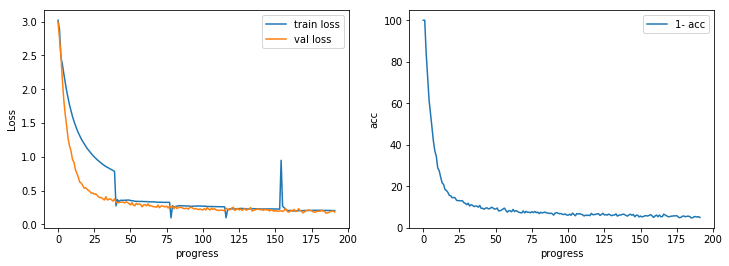

In [ ]:
#可视化训练过程
#绘制实验结果，打印测试集上的准确度
print('test acc:', right_ratio)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([i[0] for i in records2],label = 'train loss') #train loss
plt.plot([i[1] for i in records2],label = 'val loss') #val loss
plt.legend()
plt.xlabel("progress")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([100 * (1 - i[2]) for i in records2],label = '1- acc') #right ratio
plt.xlabel("progress")
plt.ylabel("acc")
plt.legend()
plt.show()

迁移，但是不训练卷积层的权重

In [ ]:
net3 = Transfer()
# 迁移网络，并设置卷积部件的权重和偏置都不计算梯度
net3.set_filter_values_nograd(pre_train)
if use_cuda:
    net3 = net3.cuda()

criterion = nn.CrossEntropyLoss()  

# 只将可更新的权重值加载到了优化器中
new_parameters = []
for para in net3.parameters():
    if not para.stop_gradient:
        new_parameters.append(para)

# 将new_parameters加载到了优化器中
optimizer3 = opt.Adam(learning_rate=0.001, parameters=new_parameters) #优化器

#记录训练过程
records3 = []

In [ ]:
# 开始训练网络net3 和之前一样的训练方法

num_epochs = 5

for epoch in range(num_epochs):
    losses = []
    for idx, data in enumerate(zip(train_loader1, train_loader2)):
        if idx >= (len(train_loader1) // fraction):
            break
        ((x1, y1), (x2, y2)) = data
        if use_cuda:
            x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
        net3.train()
        optimizer3.clear_grad()

        x1 = x1.clone().detach()
        x1.stop_gradient = False
        x2 = x2.clone().detach()
        x2.stop_gradient = False
        
        #print(x1.shape)
        outputs = net3(x1, x2)
        labels = y1 + y2
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer3.step()
        loss = loss.cpu() if use_cuda else loss
        losses.append(loss.numpy())
        if idx % 100 == 0:
            val_losses = []
            rights = []
            net3.eval()
            for val_data in zip(val_loader1, val_loader2):
                ((x1, y1), (x2, y2)) = val_data
                if use_cuda:
                    x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
                
                x1 = x1.clone().detach()
                x1.stop_gradient = False
                x2 = x2.clone().detach()
                x2.stop_gradient = False

                outputs = net3(x1,x2)
                labels = y1 + y2
                loss = criterion(outputs, labels)
                loss = loss.cpu() if use_cuda else loss
                val_losses.append(loss.numpy())
                
                right = rightness(outputs, labels) #
                rights.append(right)

            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            
            print('第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'.format(
                epoch, idx, len(train_loader1),
                np.mean(losses), np.mean(val_losses), right_ratio))
            records3.append([np.mean(losses), np.mean(val_losses), right_ratio])

#测试
rights = []
net3.eval()
for test_data in zip(test_loader1, test_loader2):
    ((x1, y1), (x2, y2)) = test_data
    if use_cuda:
        x1, y1, x2, y2 = x1.cuda(), y1.cuda(), x2.cuda(), y2.cuda()
    
    x1 = x1.clone().detach()
    x1.stop_gradient = False
    x2 = x2.clone().detach()
    x2.stop_gradient = False

    outputs = net3(x1,x2)
    labels = y1 + y2
    loss = criterion(outputs, labels)
    right = rightness(outputs, labels)
    rights.append(right)
right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
results['transfer3'] = [records3, right_ratio] 

第0周期，第(0/3750)个撮，训练误差：2.87, 校验误差：2.98, 准确率：0.08
第0周期，第(100/3750)个撮，训练误差：2.91, 校验误差：2.80, 准确率：0.10
第0周期，第(200/3750)个撮，训练误差：2.82, 校验误差：2.60, 准确率：0.14
第0周期，第(300/3750)个撮，训练误差：2.71, 校验误差：2.36, 准确率：0.19
第0周期，第(400/3750)个撮，训练误差：2.59, 校验误差：2.07, 准确率：0.29
第0周期，第(500/3750)个撮，训练误差：2.47, 校验误差：1.91, 准确率：0.35
第0周期，第(600/3750)个撮，训练误差：2.36, 校验误差：1.63, 准确率：0.46
第0周期，第(700/3750)个撮，训练误差：2.26, 校验误差：1.57, 准确率：0.47
第0周期，第(800/3750)个撮，训练误差：2.17, 校验误差：1.36, 准确率：0.55
第0周期，第(900/3750)个撮，训练误差：2.08, 校验误差：1.19, 准确率：0.62
第0周期，第(1000/3750)个撮，训练误差：2.00, 校验误差：1.12, 准确率：0.66
第0周期，第(1100/3750)个撮，训练误差：1.92, 校验误差：1.04, 准确率：0.68
第0周期，第(1200/3750)个撮，训练误差：1.85, 校验误差：0.96, 准确率：0.71
第0周期，第(1300/3750)个撮，训练误差：1.79, 校验误差：0.88, 准确率：0.73
第0周期，第(1400/3750)个撮，训练误差：1.73, 校验误差：0.88, 准确率：0.73
第0周期，第(1500/3750)个撮，训练误差：1.67, 校验误差：0.79, 准确率：0.77
第0周期，第(1600/3750)个撮，训练误差：1.62, 校验误差：0.77, 准确率：0.77
第0周期，第(1700/3750)个撮，训练误差：1.56, 校验误差：0.71, 准确率：0.79
第0周期，第(1800/3750)个撮，训练误差：1.52, 校验误差：0.68, 准确率：0.80
第0周期，第(1900/3750)个撮，训练误差：1.48, 校验误差：0.66, 准

In [ ]:
#保存模型
paddle.save(net3.state_dict(), "net3.pdparams")
paddle.save(optimizer3.state_dict(), "net3_optimizer.pdopt")

test acc: 0.9718


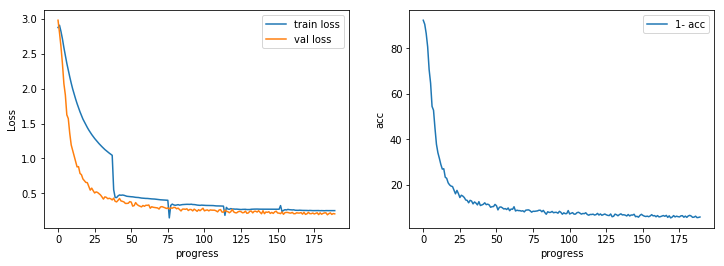

In [ ]:
#可视化训练过程
#绘制实验结果，打印测试集上的准确度
print('test acc:', right_ratio)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([i[0] for i in records3],label = 'train loss') #train loss
plt.plot([i[1] for i in records3],label = 'val loss') #val loss
plt.legend()
plt.xlabel("progress")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot([100 * (1 - i[2]) for i in records3],label = '1- acc') #right ratio
plt.xlabel("progress")
plt.ylabel("acc")
plt.legend()
plt.show()

notransfer acc: 0.9716
transfer_pretrained acc: 0.98
transfer_fixed acc: 0.9718


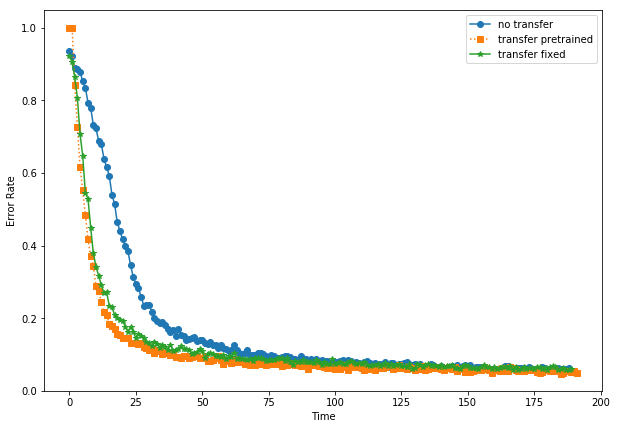

In [ ]:
#三个放在一起比较
print('notransfer acc:', results['transfer1'][1])
print('transfer_pretrained acc:', results['transfer2'][1])
print('transfer_fixed acc:', results['transfer3'][1])

y1, y2, y3 = results['transfer1'][0], results['transfer2'][0], results['transfer3'][0]  #放的是records
plt.figure(figsize = (10, 7))
plt.plot([1 - i[2] for i in y1], 'o-', label = 'no transfer')
plt.plot([1 - i[2] for i in y2], 's:', label = 'transfer pretrained')
plt.plot([1 - i[2] for i in y3], '*-', label = 'transfer fixed')
plt.xlabel('Time')
plt.ylabel('Error Rate')
plt.legend()


In [ ]:
#experiments配置
experiments = {}
#experiments[1] = results
experiments

{}

In [ ]:
# 将results保存

np.save('results.npy', results, allow_pickle=True) # 注意带上后缀名
 
# Load
#results = np.load('results.npy').item()


In [9]:
#查看devicedevice
print(paddle.device.get_device())

gpu:0


In [ ]:
results_new = {} #记载实验结果
times = 1 # 每一组参数下实验都要被重复times次
fractions = [20, 10, 8, 6, 5, 4, 3, 2, 1] #所有的数据加载的比例值
for experiment in ['no transfer', 'transfer_fixed', 'transfer_pretrained']:
    for time in range(times):
        for fraction in fractions:
            
            # 分不同的迁移学习情况加载网络和优化器
            if experiment == 'no transfer':
                net = Transfer()
                criterion = nn.CrossEntropyLoss()
                optimizer = opt.Adam(learning_rate=0.001, parameters=net.parameters()) #优化器
                
                
            if experiment == 'transfer_pretrained':
                net = Transfer()
                net.set_filter_values(pre_train)
                criterion = nn.CrossEntropyLoss()

                new_parameters = []
                for para in net.parameters():
                    if not para.stop_gradient:
                        new_parameters.append(para)
                # 将new_parameters加载到了优化器中
                optimizer = opt.Adam(learning_rate=0.001, parameters=new_parameters) #优化器
                
            if experiment == 'transfer_fixed':
                net = Transfer()
                net.set_filter_values_nograd(pre_train)
                criterion = nn.CrossEntropyLoss()

                new_parameters = []
                for para in net.parameters():
                    if not para.stop_gradient:
                        new_parameters.append(para)
                # 将new_parameters加载到了优化器中
                optimizer = opt.Adam(learning_rate=0.001, parameters=new_parameters) #优化器


                
            #开始迁移学习训练

            num_epochs = 5
            records = []
            for epoch in range(num_epochs):
                losses = []
                for idx, data in enumerate(zip(train_loader1, train_loader2)):
                    if idx >= (len(train_loader1) // fraction):
                        break
                    ((x1, y1), (x2, y2)) = data
                    net.train()
                    optimizer.clear_grad()
                    '''
                    x1 = x1.clone().detach()
                    x1.stop_gradient = False
                    x2 = x2.clone().detach()
                    x2.stop_gradient = False
                    '''

                    outputs = net(x1,x2)
                    labels = y1 + y2
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    #loss = loss.cpu() if use_cuda else loss
                    losses.append(loss.numpy())
                    if idx % 500 == 0:
                        val_losses = []
                        rights = []
                        net.eval()
                        for val_data in zip(val_loader1, val_loader2):
                            ((x1, y1), (x2, y2)) = val_data
                            '''
                            x1 = x1.clone().detach()
                            x1.stop_gradient = False
                            x2 = x2.clone().detach()
                            x2.stop_gradient = False
                            '''

                            outputs = net(x1,x2)
                            labels = y1 + y2
                            loss = criterion(outputs, labels)
                            #loss = loss.cpu() if use_cuda else loss
                            val_losses.append(loss.numpy())
                            right = rightness(outputs, labels)
                            rights.append(right)
                        right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
                        print('{}网络：第{}试验，比例{}, 第{}周期，第({}/{})个撮，训练误差：{:.2f}, 校验误差：{:.2f}, 准确率：{:.2f}'
                              .format(experiment,time,fraction,
                            epoch, idx, len(train_loader1)// fraction,
                            np.mean(losses), np.mean(val_losses), right_ratio))
                        records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            rights = []
            net.eval()
            for test_data in zip(test_loader1, test_loader2):
                ((x1, y1), (x2, y2)) = test_data
                '''
                x1 = x1.clone().detach()
                x1.stop_gradient = False
                x2 = x2.clone().detach()
                x2.stop_gradient = False
                '''

                outputs = net(x1,x2)
                labels = y1 + y2
                loss = criterion(outputs, labels)
                right = rightness(outputs, labels)
                rights.append(right)
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print(experiment,time,fraction)
            
            #将结果记录在了results_new集合之中，records记载了每一个打印周期的训练集损失函数、校验集损失函数、校验集正确率，
            #right_ratio记录了每次实验测试集的准确度
            results_new[(experiment,time,fraction)] = [records, right_ratio]  

In [ ]:
# 将results_new保存

np.save('results_new.npy', results_new, allow_pickle=True) # 注意带上后缀名
 
# Load
#load_dict = np.load('results_new.npy').item()

In [ ]:
# 处理实验数据
# 首先对于同一组参数下的数据求多次试验的平均值

one_curve = {}
tests = {}
for experiment in ['no transfer', 'transfer_pretrained', 'transfer_fixed']:
    for fraction in fractions:
        one_experiment = []
        test_value = []
        for time in range(times):
            rr = results_new[(experiment, time, fraction)]
            one_experiment.append([ii[2] for ii in rr[0]])
            test_value.append(rr[1])
        aa = np.array(one_experiment)
        #print(aa.shape)
        one_curve[(experiment, fraction)] = np.mean(aa, 0)
        tests[(experiment, fraction)] = np.mean(test_value)

In [ ]:
# 然后再绘制它们的误差曲线
for fraction in fractions:
    plt.figure(figsize = (10, 7))
    plt.title('{:.2f} % of the data'.format(100.0 / fraction))
    plt.plot(1 - one_curve[('no transfer', fraction)], label = 'no transfer')
    plt.plot(1 - one_curve[('transfer_pretrained', fraction)], label = 'transfer pretrained')
    plt.plot(1 - one_curve[('transfer_fixed', fraction)] , label = 'transfer fixed')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Error')

In [ ]:
# 绘制测试准确度随着fraction变化的曲线
plt.figure(figsize = (10, 7))
for experiment in ['no transfer', 'transfer_pretrained', 'transfer_fixed']:
    testss = []
    for fraction in fractions:
        test = 1 - tests[(experiment, fraction)]
        testss.append(test)
    plt.plot(fractions, testss, 'o-', label = experiment)
plt.legend()
plt.xlabel('Fractions')
plt.ylabel('Error Rate')

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 